# Data

In [1]:
import os
import array
import numpy as np

class DataHolder:
    def __init__(self, data_path = './korp_stats.bin'):
        self.load_data(data_path)
        
    def load_data(self, data_path):
        double_size = 8

        n_nums = int(os.path.getsize(data_path)/double_size)
        n_content = 5
        if n_nums % n_content != 0:
            print("Oops, something went wrong with the file size and contents.")
        n_entries = int(n_nums/n_content)
        F = open(data_path, 'rb')
        data = array.array('d')
        data.fromfile(F, n_nums)
        F.close()
        data = np.array(data)
        data = np.reshape(data, (n_entries, n_content))
        self.raw_data = data
        
        # NOTE: somehow there is ligand with index -1, shift all indices by one for convenience
        self.raw_data[:,1] += 1
        
        self._process_raw_data()
        
    def _process_raw_data(self):
        self.max_row = self.raw_data.max(axis=0)
        self.min_row = self.raw_data.min(axis=0)
        
        self.num_proteins = int(self.max_row[0]) + 1
        self.num_ligands = int(self.max_row[1]) + 1
        self.min_distance = self.min_row[2]
        self.max_distance = self.max_row[2]
        
    def describe(self):
        print('Dataset contains {} proteins x {} ligands, total {} points; distance range {:.2f}-{:.2f} Å'
            .format(
                self.num_proteins,
                self.num_ligands,
                len(self.raw_data),
                self.min_distance,
                self.max_distance))
        print('Min row: {}'.format(self.min_row))
        print('Max row: {}'.format(self.max_row))
        
    def get_points_for_pair(self, a, b):
        assert a < self.num_proteins
        assert b < self.num_ligands
        return self.raw_data[np.where((self.raw_data[:, 0] == a) & (self.raw_data[:, 1] == b))][:, 2:]

In [2]:
data = DataHolder()

In [49]:
data.get_points_for_pair(0, 0)

array([[16.6802361 ,  1.45493459,  5.06505856],
       [12.34081887,  2.44732327,  1.33198919],
       [14.17844983,  2.38767475,  2.52023497],
       ...,
       [17.16970868,  2.73020298,  0.76670437],
       [19.85207542,  1.95339094,  0.48944169],
       [19.82717776,  1.28358379,  0.97600928]])

In [50]:
data.describe()

Dataset contains 21 proteins x 40 ligands, total 47916041 points; distance range 2.02-20.00 Å
Min row: [0.00000000e+00 0.00000000e+00 2.01911113e+00 1.25772576e-04
 5.77119490e-08]
Max row: [20.         39.         20.          3.14115844  6.28318523]


# Density estimation

Implementation details:

1. Estimation in 3D space - no spherical prior
2. Gaussian kernel
3. 10000 random points subsample max to speed up computation

In [3]:
def spherical_to_cartesian(points):
    #u = theta / (2 * np.pi)
    #v = (np.cos(phi) + 1) / 2
    
    r = points[:,0]
    
    # 0 - pi
    phi = points[:,1]
    
    # 0 - 2pi
    theta = points[:,2]
    
    res = np.zeros(points.shape)
    res[:,0] = r * np.sin(phi) * np.cos(theta)
    res[:,1] = r * np.sin(phi) * np.sin(theta)
    res[:,2] = r * np.cos(phi)
    return res

In [121]:
def map_to_square(phi, theta):
    assert phi.max() <= np.pi + 1e-3
    assert phi.min() >= -1e-3
    
    u = theta / (2 * np.pi)
    v = (np.cos(phi) + 1) / 2
    u[u < 0] += 1
    u[u > 1] -= 1
    v[v < 0] += 1
    v[v > 1] -= 1
    return u, v

def plot_for_distance_range(data, d_min, d_max):
    data_local = data[np.where(
        (data[:, 0] > d_min) & (data[:, 0] <= d_max))
    ][:, 1:]
    
    #print(data_local.shape[0])
    if data_local.shape[0] < 10:
        return
        
    u, v = map_to_square(data_local[:,0], data_local[:,1])

    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.text(0.1, 0.85, '({},{}]'.format(d_min, d_max), color='fuchsia', fontsize=20)
    plt.scatter(u, v, s=1000.0 / len(u))
    
def plot_all_distance_ranges(data):
    plt.figure(figsize=(15, 15))
    for d in range(2, 20):
        plt.subplot(5, 4, 1 + d)
        plot_for_distance_range(data, d, d + 1)
    plt.show()
    
def plot_for_pair(a, b):
    plt.figure(figsize=(15, 15))
    sub_data = data[np.where(
            (data[:, 0] == a) &
            (data[:, 1] == b))
        ][:,:]
    print('Got', sub_data.shape[0], 'values of', data.shape[0], 'for pair', a, '-', b)
    for d in range(2, 20):
        plt.subplot(5, 4, 1 + d)
        plot_for_distance_range(sub_data, d, d + 1)
    plt.show()

In [176]:
from sklearn.neighbors import KernelDensity

class DensityEstimate:
    def __init__(self, spherical_points, description=None):
        self.description = description
        self.spherical_points = spherical_points
        self.kde = KernelDensity(
            bandwidth=0.5, metric='euclidean', kernel='gaussian', algorithm='auto', rtol=0.1)
        
        max_points_for_fit = 10000
        points = spherical_to_cartesian(spherical_points)
        np.random.shuffle(points)
        points = points[:max_points_for_fit,:]
        
        self.kde.fit(points)
        
    def get_density_grid_for_distance(self, r):
        #y_linspace = np.linspace(0, np.pi, 100)
        y_linspace = np.arccos(np.linspace(1, -1, 100))

        X, Y = np.meshgrid(np.linspace(0, 2 * np.pi, 100), y_linspace)
        probe_points = spherical_to_cartesian(np.hstack(
            [np.ones((X.size, 1)) * r, Y.ravel().reshape(X.size, 1), X.ravel().reshape(Y.size, 1)]))
        prob = np.exp(self.kde.score_samples(probe_points))
        
        return prob.reshape(X.shape)
         
    def plot_density_for_distance(self, r, fontsize=20, no_axis=False):
        plt.imshow(self.get_density_grid_for_distance(r), cmap='Greys', extent=[0, 2*np.pi, 0,np.pi], aspect=2)
        if self.description is not None:
            plt.text(0.1, np.pi*0.92, self.description, color='fuchsia', fontsize=fontsize)
        plt.text(0.1, np.pi*0.82, 'r={}Å'.format(r), color='fuchsia', fontsize=fontsize)
        
        if no_axis:
            plt.gca().set_yticklabels([])
            plt.gca().set_xticklabels([])
   
    def plot_point_cloud_for_range(self, d_min, d_max):
        plot_for_distance_range(self.spherical_points, d_min, d_max)
        
    def plot_point_cloud(self, r):
        self.plot_point_cloud_for_range(r - 0.5, r + 0.5)
        
    def comparative_plot(self, r):
        plt.figure(figsize=(14, 7))
        plt.subplot(1, 2, 1)
        self.plot_density_for_distance(r)
        plt.subplot(1, 2, 2)
        self.plot_point_cloud(r)
        plt.show()


In [128]:
def get_density_estimate_for_pair(a, b):
    spherical_points = data.get_points_for_pair(a, b)
    return DensityEstimate(spherical_points, description=('{} - {}'.format(a,b)))

# Examples (seems to work)

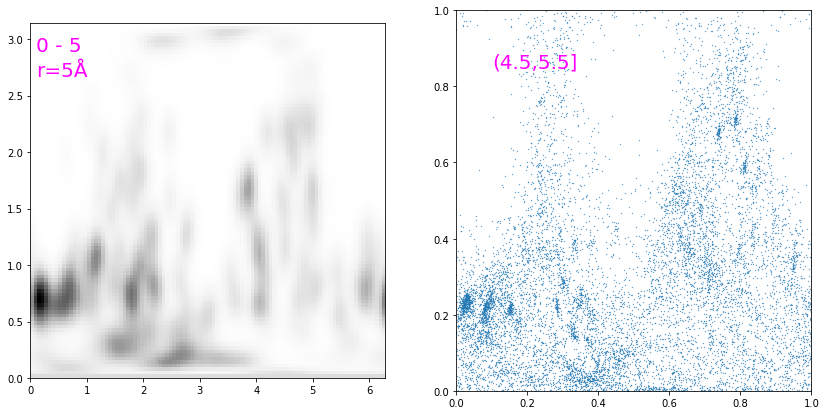

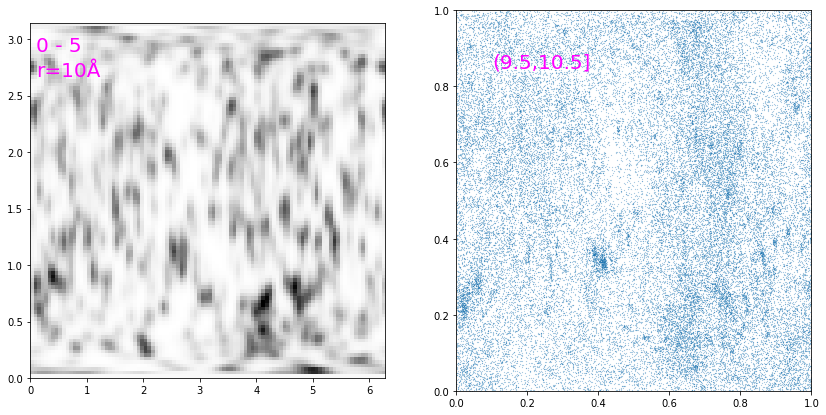

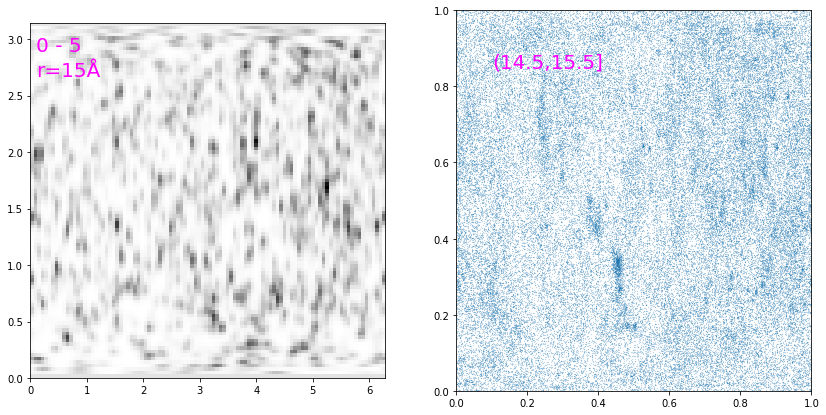

In [130]:
density = get_density_estimate_for_pair(0, 5)
density.comparative_plot(5)
density.comparative_plot(10)
density.comparative_plot(15)

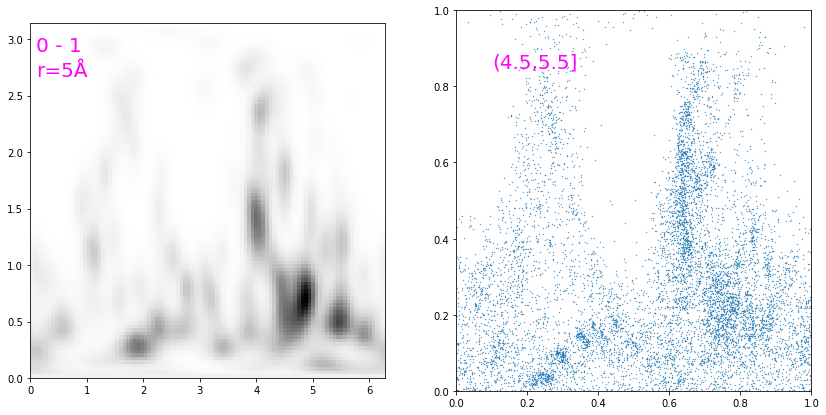

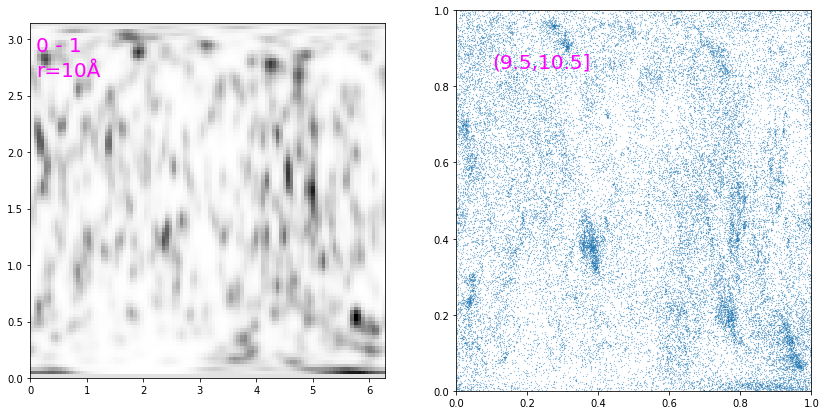

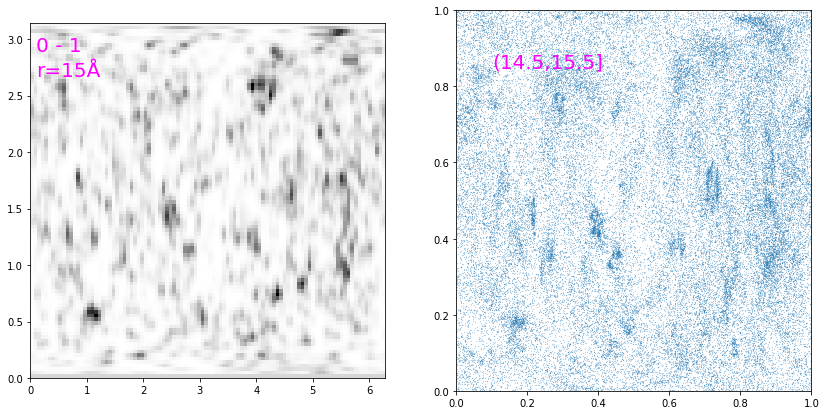

In [131]:
density = get_density_estimate_for_pair(0, 1)
density.comparative_plot(5)
density.comparative_plot(10)
density.comparative_plot(15)

In [177]:
# 21 x 40
# 

from matplotlib.backends.backend_pdf import PdfPages

def plot_for_protein(protein, r=5, pdf_file=None):
    num_ligands = 40
    per_row = 5
    
    assert num_ligands % per_row == 0
    total_rows = num_ligands // per_row
    #total_rows = 2
    #for row in range(num_ligands // per_row):
    plt.figure(figsize=(18,5 * total_rows))
    for row in range(total_rows):
        for i in range(per_row):
            print('Plotting {}'.format(row * per_row + i + 1))
            density = get_density_estimate_for_pair(protein, row * per_row + i)
            plt.subplot(total_rows, per_row, row * per_row + i + 1)
            density.plot_density_for_distance(r, fontsize=10, no_axis=True)
    if pdf_file is not None:
        pdf_file.savefig(plt.gcf())
    plt.show()

Plotting 1
Plotting 2
Plotting 3
Plotting 4
Plotting 5
Plotting 6
Plotting 7
Plotting 8
Plotting 9
Plotting 10
Plotting 11
Plotting 12
Plotting 13
Plotting 14
Plotting 15
Plotting 16
Plotting 17
Plotting 18
Plotting 19
Plotting 20
Plotting 21
Plotting 22
Plotting 23
Plotting 24
Plotting 25
Plotting 26
Plotting 27
Plotting 28
Plotting 29
Plotting 30
Plotting 31
Plotting 32
Plotting 33
Plotting 34
Plotting 35
Plotting 36
Plotting 37
Plotting 38
Plotting 39
Plotting 40


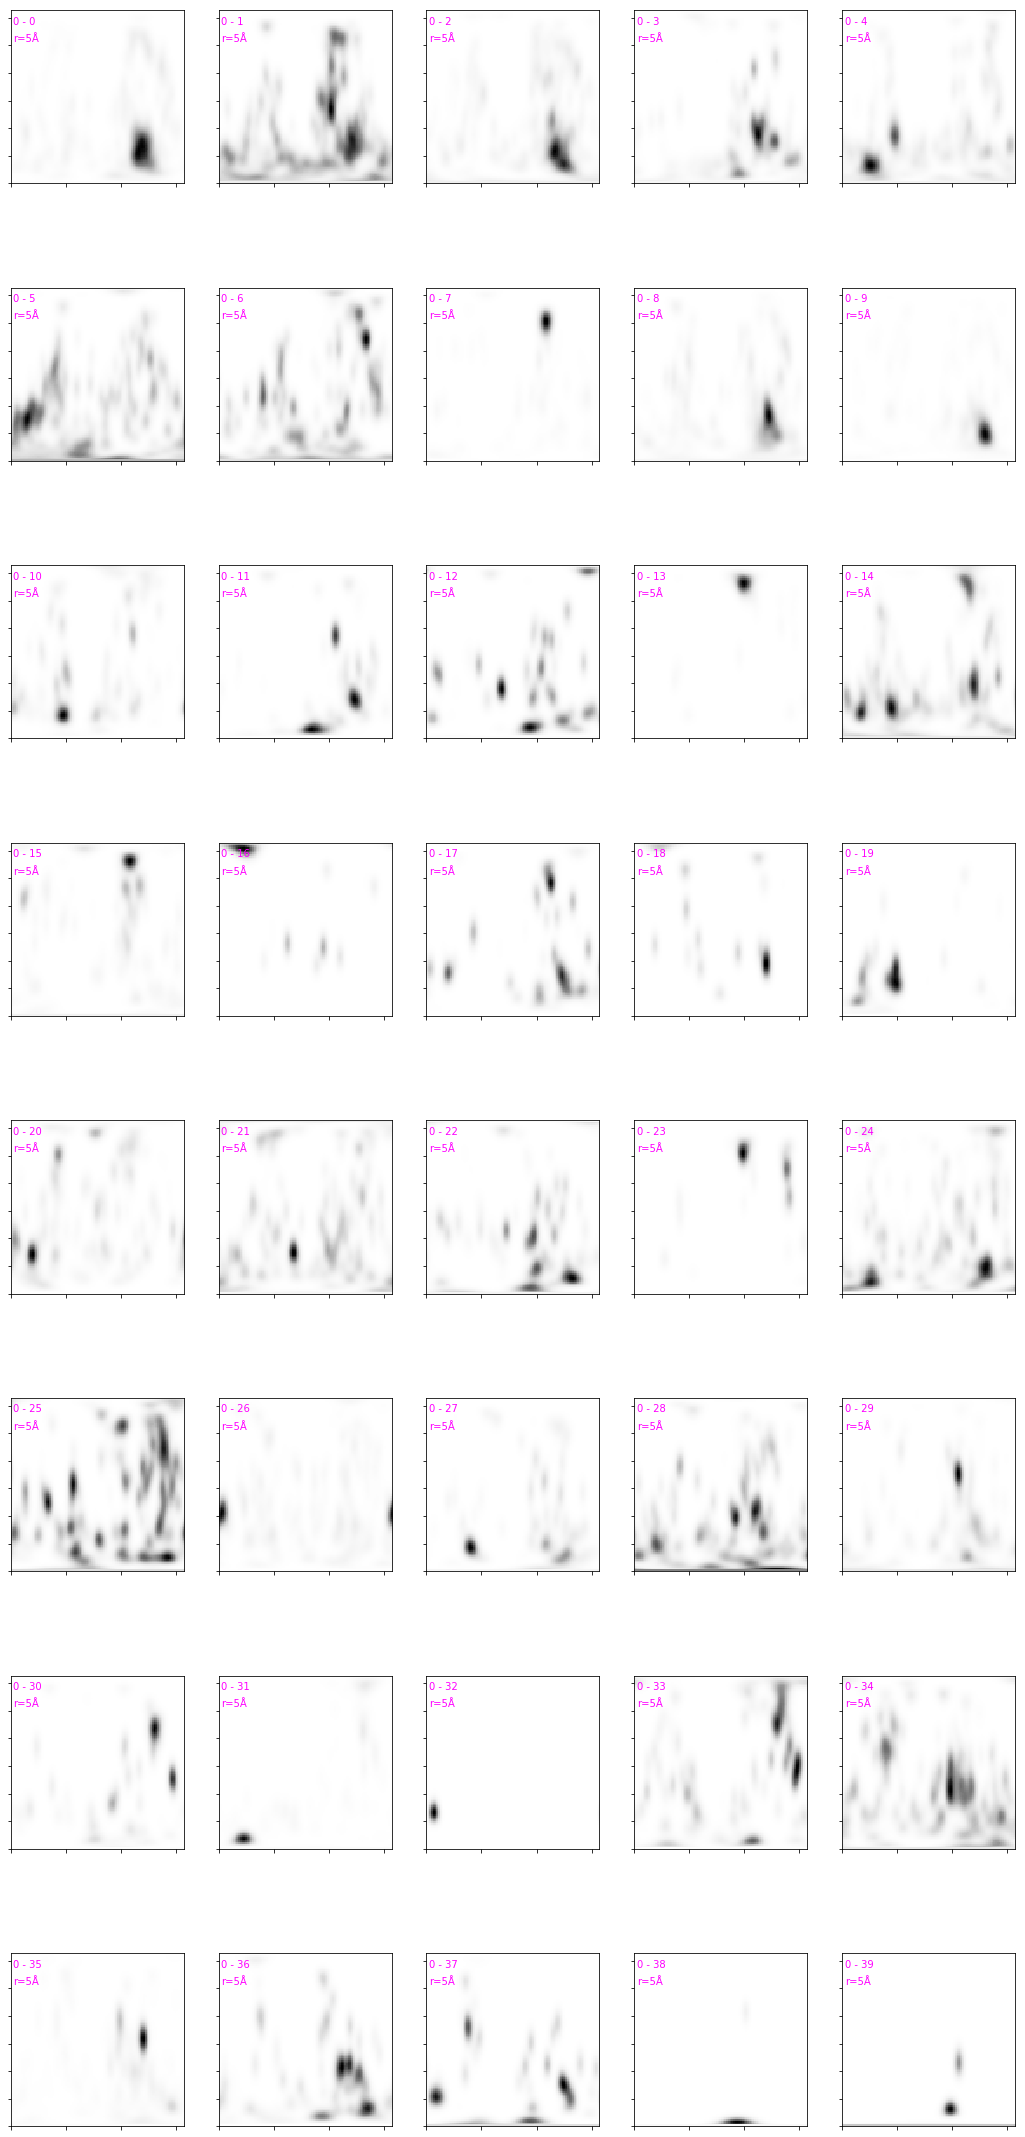

Plotting 1
Plotting 2
Plotting 3
Plotting 4
Plotting 5
Plotting 6
Plotting 7
Plotting 8
Plotting 9
Plotting 10
Plotting 11
Plotting 12
Plotting 13
Plotting 14
Plotting 15
Plotting 16
Plotting 17
Plotting 18
Plotting 19
Plotting 20
Plotting 21
Plotting 22
Plotting 23
Plotting 24
Plotting 25
Plotting 26
Plotting 27
Plotting 28
Plotting 29
Plotting 30
Plotting 31
Plotting 32
Plotting 33
Plotting 34
Plotting 35
Plotting 36
Plotting 37
Plotting 38
Plotting 39
Plotting 40


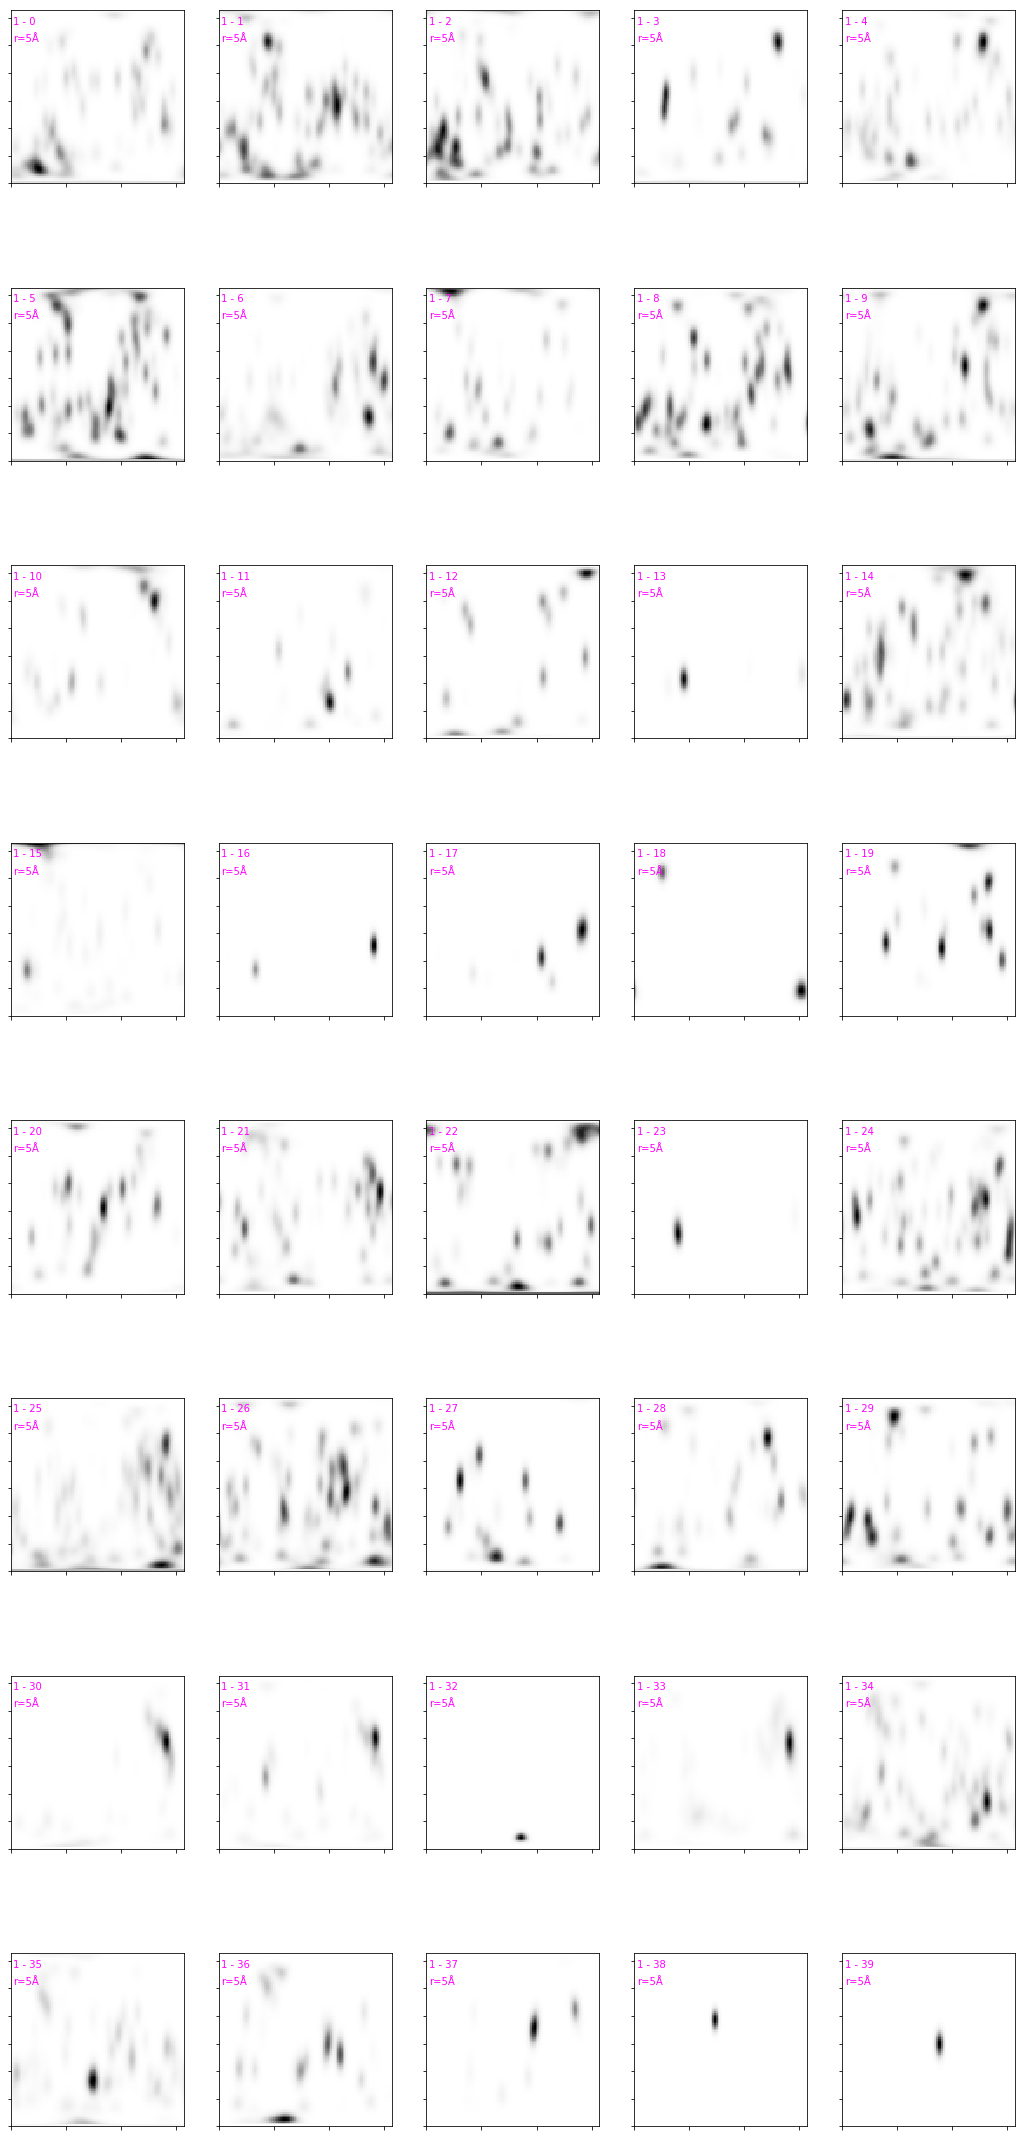

Plotting 1
Plotting 2
Plotting 3
Plotting 4
Plotting 5
Plotting 6
Plotting 7
Plotting 8
Plotting 9
Plotting 10
Plotting 11
Plotting 12
Plotting 13
Plotting 14
Plotting 15
Plotting 16
Plotting 17
Plotting 18
Plotting 19
Plotting 20
Plotting 21
Plotting 22
Plotting 23
Plotting 24
Plotting 25
Plotting 26
Plotting 27
Plotting 28
Plotting 29
Plotting 30
Plotting 31


In [ ]:
r = 5
protein_from = 0
protein_to = 5
with PdfPages('proteins_{}_{}_radius_{}.pdf'.format(protein_from, protein_to - 1, r)) as pdf:
    for protein in range(protein_from, protein_to):
        plot_for_protein(protein, r=r, pdf_file=pdf)

# Junk (do not look here)

In [168]:
spherical_points = data.get_points_for_pair(0, 5)

In [169]:
def get_artificial():
    pts = np.zeros((10, 3))
    pts[:,0] = 5
    pts[:,1] = np.pi / 2 + np.random.randn(10) * 0.1
    pts[:,2] = np.pi
    return pts

#spherical_points = get_artificial()

In [170]:
points = spherical_to_cartesian(spherical_points)

In [171]:
print(len(points), points.shape)

954266 (954266, 3)


In [172]:
from sklearn.neighbors import KernelDensity

kde = KernelDensity(bandwidth=0.5, metric='euclidean', kernel='gaussian', algorithm='auto', rtol=0.1)

In [173]:
%time kde.fit(points)

CPU times: user 1.41 s, sys: 230 µs, total: 1.41 s
Wall time: 1.4 s


KernelDensity(algorithm='auto', atol=0, bandwidth=0.5, breadth_first=True,
              kernel='gaussian', leaf_size=40, metric='euclidean',
              metric_params=None, rtol=0.1)

In [174]:
#np.exp(kde.score_samples(xy))
#xy need to be flattened (x, y, z) triples

In [175]:
#y_linspace = np.linspace(0, np.pi, 100)
y_linspace = np.arccos(np.linspace(1, -1, 100))

X, Y = np.meshgrid(np.linspace(0, 2 * np.pi, 100), y_linspace)

In [176]:
X.size

10000

In [177]:
# mind the swapping
r = 5
probe_points = spherical_to_cartesian(np.hstack([np.ones((X.size, 1)) * r, Y.ravel().reshape(X.size, 1), X.ravel().reshape(Y.size, 1)]))

In [178]:
prob = np.exp(kde.score_samples(probe_points))

In [179]:
prob

array([8.33291392e-06, 8.33291392e-06, 8.33291392e-06, ...,
       1.20111491e-04, 1.20111491e-04, 1.20111491e-04])

In [180]:
import matplotlib.pyplot as plt

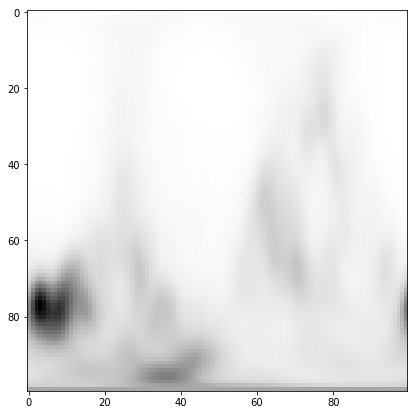

In [181]:
plt.figure(figsize=(7,7))
plt.imshow(prob.reshape(X.shape), cmap='Greys')
plt.show()